In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2024-10-11 21:17:09.156443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 21:17:09.166386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 21:17:09.169192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 21:17:09.177345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 21:17:09.801015: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1728674230.347589   23290 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674230.362332   23290 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728674230.362391   23290 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


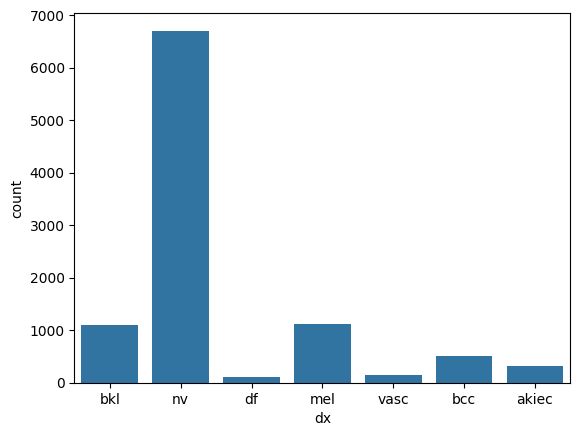

In [3]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  # Folder where the images are stored

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.show()

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)


In [4]:
print(train_df['label'].unique())  
print(val_df['label'].unique())    
print(test_df['label'].unique())   

[4 0 3 5 2 6 1]
[5 2 1 0 4 3 6]
[5 4 2 1 3 0 6]


In [5]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


In [6]:
image_size = (64, 64)  
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7210 validated image filenames belonging to 7 classes.
Found 802 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [7]:
class CustomCNN(models.Model):
    def __init__(self, layers_list):
        super(CustomCNN, self).__init__()
        self.model = models.Sequential()
        for layer in layers_list:
            self.model.add(layer)
    
    def call(self, inputs):
        return self.model(inputs)

def create_custom_cnn(input_shape, num_classes):
    layers_list = [
        layers.Input(input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ]
    
    model = CustomCNN(layers_list)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [17]:
input_shape = (64, 64, 3)  
num_classes = len(df['label'].unique())



model = create_custom_cnn(input_shape, num_classes)

epochs = 5

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

import time
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


model.save('cnn5epoch.keras')


/home/bosa/manu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 461ms/step - accuracy: 0.6209 - loss: 1.2213 - val_accuracy: 0.6696 - val_loss: 1.0234
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


2024-10-11 21:15:07.878464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1855793616886468820
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-11 21:15:07.878503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17385324377489151592
2024-10-11 21:15:07.881704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1855793616886468820
2024-10-11 21:15:07.881735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17385324377489151592


57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.6717 - loss: 0.9901 - val_accuracy: 0.6721 - val_loss: 0.9286
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5


2024-10-11 21:15:34.838611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1855793616886468820
2024-10-11 21:15:34.838654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17385324377489151592
2024-10-11 21:15:34.841208: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-11 21:15:34.841235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1855793616886468820
2024-10-11 21:15:34.841252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17385324377489151592


57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 496ms/step - accuracy: 0.6721 - loss: 0.9300 - val_accuracy: 0.6758 - val_loss: 0.9147
Training time: 88.47 seconds


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.6652 - loss: 1.0541
Test Accuracy: 0.6694957613945007
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step
ROC AUC Score: 0.5256461990697056
F1 Score: 0.5369580199079372


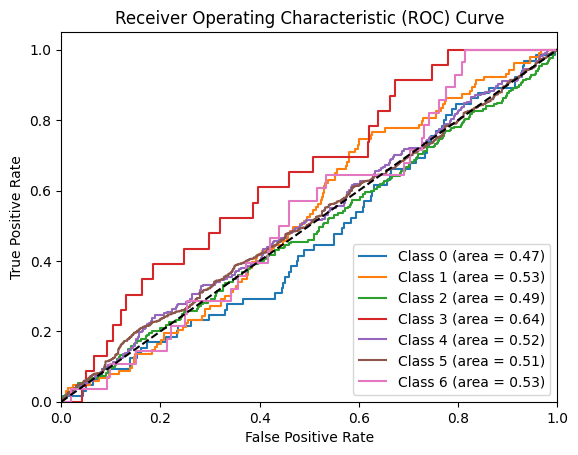

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

# Get the true labels and predicted probabilities
y_true = test_df['label'].astype(int)
y_pred_prob = model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)

# Calculate ROC AUC score
roc_auc = roc_auc_score(to_categorical(y_true), y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Plot ROC AUC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()